# HW1: LeNet-5 with Post-training Quantization and Quantization Aware Training
[LeNet](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) is considered to be the first ConvNet.
We are going to implement a neural architecture similar to LeNet and train it with [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset.

Before we start, you may check this [Tensorspace-LeNet](https://tensorspace.org/html/playground/lenet.html) to play with LeNet and get familiar with this neural architecture.

![image](https://production-media.paperswithcode.com/methods/LeNet_Original_Image_48T74Lc.jpg)
Ref.: LeCun et al., Gradient-Based Learning Applied to Document Recognition, 1998a

## 1. Initial Setup

We are going to implement and train this nerual network with PyTorch.
If you are not familer with PyTorch, check [official tutorail](https://pytorch.org/tutorials/beginner/basics/intro.html)

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [11]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch import optim
from torch.utils.data import DataLoader
import numpy as np
import random
#from quantutils import copy_model
from copy import deepcopy
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 1.1 Load dataset
Load training and test data from the MNIST dataset.

In [12]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

transform = transforms.Compose(
    [
     transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))
    ])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0,
                                          worker_init_fn=seed_worker, generator=g,)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=0,
                                         worker_init_fn=seed_worker, generator=g,)

### 1.2 Define the Neural Network
Define a simple CNN that classifies MNIST images.

In [13]:
from collections import OrderedDict
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(1, 6, 5, bias=False)),
            ('relu', nn.ReLU()),
        ]))

        self.maxpool2 = nn.Sequential(OrderedDict([
            ('pool', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))

        self.conv3 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(6, 16, 5, bias=False)),
            ('relu', nn.ReLU())
        ]))

        self.maxpool4 = nn.Sequential(OrderedDict([
            ('pool', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))

        self.conv5 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(16, 120, 5, bias=False)),
            ('relu', nn.ReLU())
        ]))

        self.fc6 = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(120, 84, bias=False)),
            ('relu', nn.ReLU())
        ]))

        self.output = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(84, 10, bias=False)),
        ]))


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool4(x)
        x = self.conv5(x)
        x = torch.flatten(x, 1)
        x = self.fc6(x)
        x = self.output(x)
        return x

NET = Net().to(device)

### 1.3 Question: Profile the Neural Architecture by TorchInfo
Torchinfo provides information complementary to what is provided by print(your_model) in PyTorch, similar to Tensorflow's model.summary() API to view the visualization of the model, which is helpful while debugging your network. Check this [link](https://github.com/TylerYep/torchinfo#how-to-use) about how to use TorchInfo by `summary()` and fill in the TODO in the following cell. You should get the result similar to the table below:

```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
LeNet                                    --                        --
...
...
==========================================================================================
Total params: ...
...
Estimated Total Size (MB): ...
==========================================================================================
```


Ref.: https://github.com/TylerYep/torchinfo

Please read *B. LeNet-5* in the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) and answer the following questions.
1. Include the output of `summary()` into the report 
2. Provide the type (convolution, pooling, fully-connected layer, etc.), input activation size, output activation size, and activation function (if any) of each layer in a table format.
3. What is the difference between this neural architecture and the lenet-5 in the original paper?
4. Could we replace the 3rd conv, the conv in conv5, with a fully connected layer?

In [14]:
#!pip install torchinfo
from torchinfo import summary
# TODO
model = Net()
batch_size = 16
summary(model, input_size = (batch_size, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [16, 10]                  --
├─Sequential: 1-1                        [16, 6, 28, 28]           --
│    └─Conv2d: 2-1                       [16, 6, 28, 28]           150
│    └─ReLU: 2-2                         [16, 6, 28, 28]           --
├─Sequential: 1-2                        [16, 6, 14, 14]           --
│    └─MaxPool2d: 2-3                    [16, 6, 14, 14]           --
├─Sequential: 1-3                        [16, 16, 10, 10]          --
│    └─Conv2d: 2-4                       [16, 16, 10, 10]          2,400
│    └─ReLU: 2-5                         [16, 16, 10, 10]          --
├─Sequential: 1-4                        [16, 16, 5, 5]            --
│    └─MaxPool2d: 2-6                    [16, 16, 5, 5]            --
├─Sequential: 1-5                        [16, 120, 1, 1]           --
│    └─Conv2d: 2-7                       [16, 120, 1, 1]           48,000
│    └─

### 1.4 Train and Test the Neural Network
Train this CNN on the training dataset (this may take a few moments).
* Check how to save and load the model
    * https://pytorch.org/tutorials/beginner/saving_loading_models.html
    * Save:
        ```
        torch.save(model.state_dict(), PATH)
        ```
    * Load:
        ```
        model = TheModelClass(*args, **kwargs)
        model.load_state_dict(torch.load(PATH))
        model.eval()
        ```
* After training the model, we will save it as `lenet.pt`.
* You can comment out `train(NET, trainloader, 2)` and uncomment `NET.load_state_dict(torch.load('lenet.pt'))` to load the trained model. 
    * Reloading the model from `lenet.pt` can save your time if there is something wrong and you need to restart and run all.

In [15]:
def train(model: nn.Module, dataloader: DataLoader, num_epoch):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader):

            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        print(test(model, testloader, None))
    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None, device=device) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:

            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += inputs.shape[0]
                if n_inferences > max_samples:
                    break

    return 100 * correct / total

In [16]:
train(NET, trainloader, 2)
# NET.load_state_dict(torch.load('lenet.pt'))
score = test(NET, testloader, None)
print('Accuracy of the network on the test images: {}%'.format(score))

torch.save(NET.state_dict(), 'lenet.pt')

[1,  2000] loss: 0.378
[1,  4000] loss: 0.132
[1,  6000] loss: 0.117
[1,  8000] loss: 0.092
[1, 10000] loss: 0.093
[1, 12000] loss: 0.085
[1, 14000] loss: 0.075
97.5
[2,  2000] loss: 0.060
[2,  4000] loss: 0.071
[2,  6000] loss: 0.066
[2,  8000] loss: 0.068
[2, 10000] loss: 0.056
[2, 12000] loss: 0.063
[2, 14000] loss: 0.069
98.28
Finished Training
Accuracy of the network on the test images: 98.28%


## 2. Post-training Quantization
### 2.1 Question: Visualize Weights

We have flattened all vector for you by `tensor.view(-1)`.

1. Try plotting a histogram of each weight, put results in the report. hint: `np.histogram()` and `plt.hist()`

1. Record the range of the weights, as well as their 3-sigma range (the difference between $\mu + 3\sigma$ and $\mu - 3\sigma$).
For which layers is the 3-sigma range larger or smaller than the actual range?
2. Explain which range you would prefer to use if you were to quantize each layer's weights and wanted to strike a balance between the range of values that could be expressed.

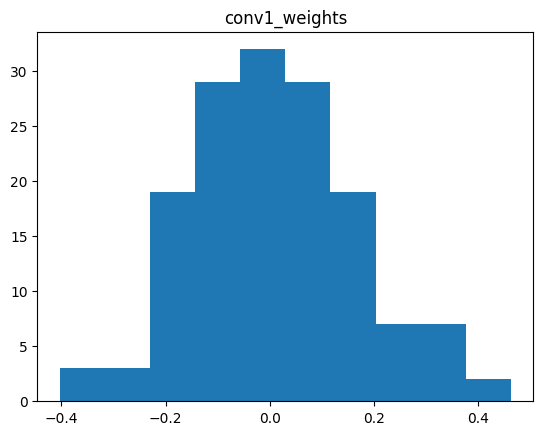

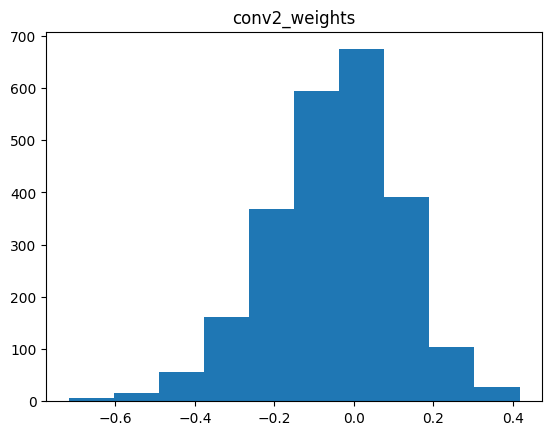

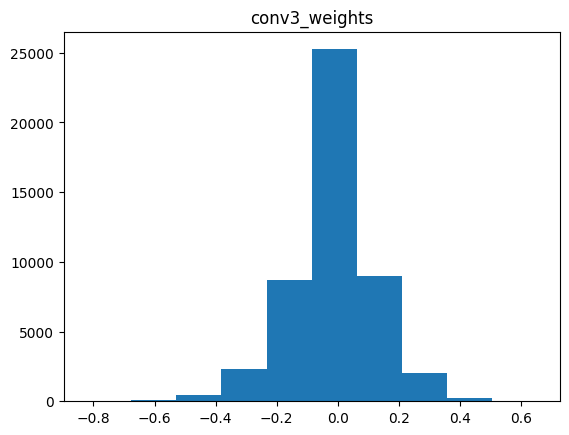

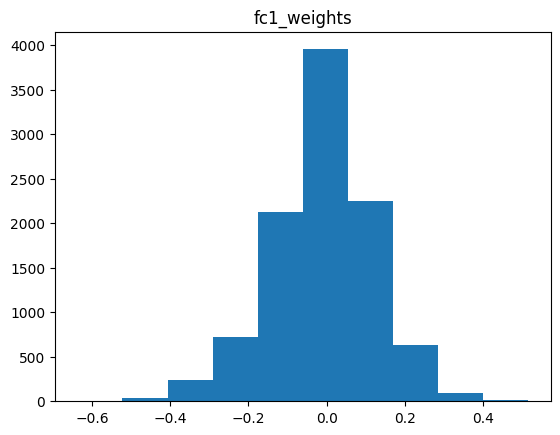

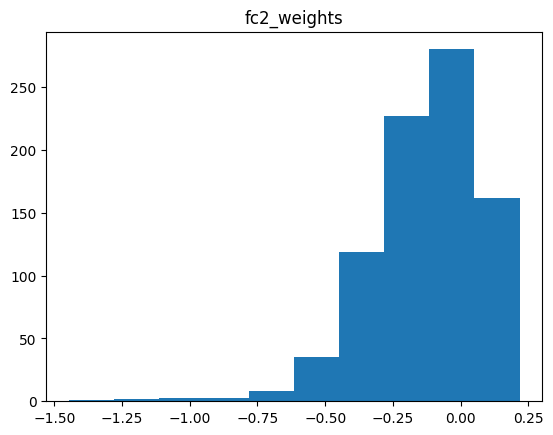

In [17]:
import matplotlib.pyplot as plt

conv1_weights = NET.conv1[0].weight.data.cpu().view(-1)
conv2_weights = NET.conv3[0].weight.data.cpu().view(-1)
conv3_weights = NET.conv5[0].weight.data.cpu().view(-1)
fc1_weights = NET.fc6[0].weight.data.cpu().view(-1)
fc2_weights = NET.output[0].weight.data.cpu().view(-1)

weightDict = {
    'conv1_weights':conv1_weights,
    'conv2_weights': conv2_weights,
    'conv3_weights': conv3_weights,
    'fc1_weights': fc1_weights,
    'fc2_weights':fc2_weights
}

# TODO
for _, weight in weightDict.items():
  __, bin = np.histogram(weight)
  plt.hist(weight, bin)
  plt.title(_)
  plt.show()

### 2.2 Question:  Quantize Weights
Computation of convolution or fully-connected layer can be expressed as

$$W \times I = O$$

where $W$ is the weight tensor, $I$ is the input tensor, and $O$ is the output tensor.
Let $s_W$ be the scaling factor. We have

$$s_W W_q \times I \approx W \times I = O$$

where $W_q$ is the quantized 8-bit signed integer weight tensor.

Fill in the TODO in `quantized_weights()` located in `quantutils.py`. If you’ve done everything correctly, the accuracy degradation should be negligible (~1%).
1. What is $s_W$? Explain how you get it.
2. What is the accuracy degradation?

In [21]:
from quantutils import quantized_weights
from quantutils import copy_model
net_q2 = copy_model(NET)

def quantize_layer_weights(model: nn.Module):
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Exception: Quantized weights of Conv2d layer include values out of bounds for an 8-bit signed integer

### 2.3 Question: Visualize Activations
1. Try plotting histograms the input images and the output activations of each operation, put results in the report. hint: `np.histogram()` and `plt.hist()`

2. Record the range of the values, as well as their 3-sigma range (the difference between $\mu + 3\sigma$ and $\mu - 3\sigma$).
For which layers is the 3-sigma range larger or smaller than the actual range?
3. Explain which range you would prefer to use if you were to quantize each layer's output activations and wanted to strike a balance between the range of values that could be expressed.

In [ ]:
net_q3 = copy_model(NET)

def visualize_activations(module, input, output):
    if module.profile_activations is True:
        module.inAct = input[0].cpu().reshape(-1)
        module.outAct = output[0].cpu().reshape(-1)

for name, model in net_q3.named_children():
    print("{}\n [register_forward_hook]: {}".format(name, model))
    model.profile_activations = True
    model.register_forward_hook(visualize_activations)
net_q3.eval()
with torch.no_grad():
    input = trainset[0][0].unsqueeze(0)
    _ = net_q3(input.to(device))
for name, model in net_q3.named_children():
    model.profile_activations = False

In [ ]:
input_activations = net_q3.conv1.inAct
conv1_output_activations = net_q3.conv1.outAct
conv3_output_activations = net_q3.conv3.outAct
conv5_output_activations = net_q3.conv5.outAct
fc6_output_activations = net_q3.fc6.outAct
output_output_activations = net_q3.output.outAct

actDict = {
    'input_activations':input_activations,
    'conv1_output_activations':conv1_output_activations,
    'conv3_output_activations':conv3_output_activations,
    'conv5_output_activations':conv5_output_activations,
    'fc6_output_activations':fc6_output_activations,
    'output_output_activations':output_output_activations
}

# TODO


### 2.4 Question:  Quantize Activations
The output of conv in conv1 can be expressed as 
$$W_{conv1}\times I=O_{conv1}.$$

Let the scaling factor of the input matrix $I$ be $s_I$, the scaling factor of the weight matrix $W_{conv1}$
be $s_{W_{conv1}}$, and the scaling factor of the output matrix $O_{conv1}$ be $s_{O_{conv1}}$. Then we have

$$s_{W_{conv1}} W_{conv1_q} \times s_I I_q \approx W_{conv1} \times I = O_{conv1} \approx s_{O_{conv1}}O_{conv1_q}$$

where $W_{conv1_q}$ is the quantized 8-bit signed integer weight tensor, $I_q$ is the quantized 8-bit signed integer input activation tensor, and $O_{conv1_q}$ is the quantized 8-bit signed integer output activation tensor.

Since we're doing post-training quantization, we can get $s_I$, $s_{W_{conv1}}$, and $s_{O_{conv1}}$ first and do the calculations of a scaling factor $M_1$. The layer output should be multiplied by $M_{layer}$ before being fed into the next layer.

As for `forward()` of `NetQuantized()` in `quantutils.py`, make sure you can simulate fixed-point representation when doing any calculation with input/output scale. Keep in mind that we will implement hardware to accelerate this model with fixed-point computations.
* In this assignment, we only "emulate" fixed-point computations. We don't need to use any fixed-point data type (e.g., `int`).
* You will have to fill in the TODO in `forward()` to scale the outputs of each layer. Consider rounding binary fractions to the 16th place with the following steps (e.g., for output_scale):
  1. `scale = round(scale*(2**16))`: Now, we have the `scale` rounded to the 16th place with a software trick of moving the binary point (`*(2**16)`) and applying the round function.
  2. `(scale*features) >> 16`: Move back the binary point.
  3. Two options for emulating bit-shifting in fixed-point numbers instead of floating-point numbers:
       - 1.`(scale*features) >> 16`. Make sure that the data type of `(scale*features)` is **int**.
       - 2.`floor((scale*features) >> 16)`
  4. Clamp the value between -128 and 127
* Also, don't forget to scale the input features before feeding them into the first layer.
  * Originally, we may perform the computation with `round(input_features/s_I)`. However, since `1/s_I` is much greater than 1, we prefer to use `round(1/s_I)*input_features` for hardware implementation considerations. This is the reason why we ask you to return `1/s_I` in `quantize_initial_input()`.
  * The `input_scale` stored in the model should be `1/s_I`.
    

Answer the following questions.

1. How to compute $s_I$, $s_{W_{conv1}}$, and $s_{O_{conv1}}$?
2. The true quantized output activation tensor depends on $W_{conv1_q}$ and $I_q$, so we cannot simply apply only $s_{O_{conv1}}$ on the output of $W_{conv1_q}\times I_q$ to re-quantize the output activation. \
Derive an equation for the quantized output of the conv in conv1 after quantizing input activation and weight with $s_I$ and $s_{W_{conv1}}$. And show the scaling factor $M_1$. \
(hint: $M_1$ is the scaling factor of the $O'$ in $W_{conv1_q} \times I_q = O'$, such that $M_1\times(W_{conv1_q} \times I_q) = M_1\times(O') = O_q$)
3. Derive an equation for the quantized output of the conv in conv3 after quantizing input activation and weight.
4. Show the general equantion of each layer for calculating the scaling factor $M$ of output activation.

Fill in the TODO in `class NetQuantized(nn.Module)` located in `quantutils.py`. If you’ve done everything correctly, the accuracy degradation should be negligible (~1%).

In [ ]:
from quantutils import NetQuantized

net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.conv1.inAct)

for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    layer_init.inAct = deepcopy(layer_q3.inAct)
    layer_init.outAct = deepcopy(layer_q3.outAct)

net_quantized = NetQuantized(net_init)

In [ ]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

Answer the following questions.(hint: please consider verilog implementation):

6. What is the benefit of using `floor`?
7. What is the benefit of replacing `x*output_scale` with `x/round(1/output_scale)`?

In [ ]:
print("input_scale:\n", net_quantized.input_scale.item())
print("output_scale:\n {}\n {}\n {}\n {}\n {}".format(
    net_quantized.conv1.output_scale.item(),
    net_quantized.conv3.output_scale.item(),
    net_quantized.conv5.output_scale.item(),
    net_quantized.fc6.output_scale.item(),
    net_quantized.output.output_scale.item()
))

print("input_scale:\n", net_quantized.input_scale.item())
print("output_scale:\n {}\n {}\n {}\n {}\n {}".format(
    round(1/net_quantized.conv1.output_scale.item()),
    round(1/net_quantized.conv3.output_scale.item()),
    round(1/net_quantized.conv5.output_scale.item()),
    round(1/net_quantized.fc6.output_scale.item()),
    round(1/net_quantized.output.output_scale.item())
))

### 2.5 Question:  Quantize Biases
We add a bias in the final layer of this LeNet. Now the equation is

$$s_W W_q \times s_I I_q + s_{\beta} \beta_q \approx W \times I + \beta = O \approx s_O O_q$$

where $s_W$ is the scaling factor of the weight matrix $W$, $s_I$ is the scaling factor of the input matrix $I$, $s_{\beta}$ is the scaling factor of the bias $\beta$ and, $s_O$ is the scaling factor of the output matrix $O$.

Note that our biases are commonly quantized to 32-bits

* You can comment out `train(NET_WITH_BIAS, trainloader, 2)` and uncomment `NET_WITH_BIAS.load_state_dict(torch.load('lenet_with_bias.pt'))` to load the quantized model.
    * Reloading the model from `lenet_with_bias.pt` can save your time if there is something wrong and you need to restart and run all.

Answer the following questions.
1. What is the scaling factor for the bias?\
(hint: we want the equation to be $M \times(W_q \times I_q + \beta_q) = O_q$)

Fill in the TODO in `class NetQuantizedWithBias(NetQuantized)` located in `quantutils.py`. If you’ve done everything correctly, the accuracy degradation should be negligible (~1%).

In [ ]:
class NetWithBias(Net):
    def __init__(self):
        super(NetWithBias, self).__init__()

        self.output = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(84, 10, bias=True)),
        ]))

NET_WITH_BIAS = NetWithBias().to(device)

In [ ]:
train(NET_WITH_BIAS, trainloader, 2)
# NET_WITH_BIAS.load_state_dict(torch.load('lenet_with_bias.pt'))
score = test(NET_WITH_BIAS, testloader)
print('Accuracy of the network (with a bias) on the test images: {}%'.format(score))
torch.save(NET_WITH_BIAS.state_dict(), 'lenet_with_bias.pt')

In [ ]:
for name, model in NET_WITH_BIAS.named_children():
    # print("{}\n [register_forward_hook]: {}".format(name, model))
    model.profile_activations = True
    model.register_forward_hook(visualize_activations)
NET_WITH_BIAS.eval()
with torch.no_grad():
    input = trainset[0][0].unsqueeze(0)
    _ = NET_WITH_BIAS(input.to(device))
for name, model in NET_WITH_BIAS.named_children(): model.profile_activations = False

In [ ]:
net_with_bias_with_quantized_weights = copy_model(NET_WITH_BIAS)
quantize_layer_weights(net_with_bias_with_quantized_weights)

score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

In [ ]:
from quantutils import NetQuantizedWithBias
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights)

score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network on the test images after all the weights and the bias are quantized: {}%'.format(score))

## 3. Quantization Aware Training (QAT)
Before proceeding with Part 3, please consider the following points:
1. To convert QAT models to models with zero point as zero for easier hardware implementation in the future, we have switched the backend from fbgemm to qnnpack. However, not all devices support qnnpack. 
* Try `print(torch.backends.quantized.supported_engines)` to check if qnnpack is supported. If qnnpack is not listed, try switch to using Colab. 
* When using Colab, please select CPU and avoid selecting GPU or other accelerators to ensure qnnpack can run properly.
* <font color='red'>After switching the device to CPU, make sure to rerun 1.4, cell of `def train`, to ensure device consistency. </font>
2. You can comment out `train(MODEL_FP32, trainloader, 2)` and uncomment `MODEL_FP32.load_state_dict(torch.load('MODEL_FP32.pt'))` to load the model.
    * Reloading the model from `MODEL_FP32.pt` can save your time if there is something wrong and you need to restart and run all.

### 3.1 Question: QAT
Try to trace code and study the quantization-aware training (QAT) from [Quantization — PyTorch 1.13 documentation](https://pytorch.org/docs/stable/quantization.html), then answer the following question.

1. How can the QAT achieve a higher accuracy than the post-training quantization (PTQ)?
2. Two more layers (quant, dequant) appeared after we quantized our model using the PyTorch QAT method. What do these two layers do?

In [ ]:
#check if qnnpack is supported
print(torch.backends.quantized.supported_engines)

In [ ]:
#switch device to cpu if needed
device=torch.device('cpu')
#rerun 1.4, cell of `def train` now

In [ ]:
class QATNet(NetWithBias):
    def __init__(self):
        super().__init__()
        # QuantStub converts tensors from floating point to quantized
        self.quant = torch.quantization.QuantStub()
        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = super().forward(x)
        x = self.dequant(x)
        return x


In [ ]:
qcfg = torch.quantization.get_default_qat_qconfig('qnnpack')
qact = torch.quantization.FakeQuantize.with_args(observer=torch.quantization.MovingAverageMinMaxObserver,
                             quant_min=-128, quant_max=127, dtype=torch.qint8,
                             qscheme=torch.per_tensor_symmetric, reduce_range=False)
qcfg = torch.quantization.QConfig(activation=qact, weight=qcfg.weight)

In [ ]:
# define the model
MODEL_FP32 = QATNet().to(device)

# prepare the model for QAT
MODEL_FP32.train()
# Specify quantization configuration
torch.backends.quantized.engine = 'qnnpack'
MODEL_FP32.qconfig = qcfg
torch.quantization.prepare_qat(MODEL_FP32, inplace=True)

train(MODEL_FP32, trainloader, 2)
# MODEL_FP32.load_state_dict(torch.load('MODEL_FP32.pt'))
score = test(MODEL_FP32, testloader)
print('Accuracy of the MODEL_FP32: {}%'.format(score))
torch.save(MODEL_FP32.state_dict(), 'MODEL_FP32.pt')

# convert the model to a quantized model
torch.quantization.convert(MODEL_FP32, inplace=True)

# evaluate the model on the test set
MODEL_FP32.eval()


device=torch.device('cpu')
score = test(MODEL_FP32, testloader)
print('Accuracy of the quantized LeNet-5 model on the test images: {}%'.format(score))

### Extract weight, floating-point bias and floating-point scale of activations and weights of every layer.

In [ ]:
import os
import zipfile
# It is easier to download all the files with zip
zf = zipfile.ZipFile('parameters.zip', 'w', zipfile.ZIP_DEFLATED)

In [ ]:
if not os.path.exists('./weights'):
    os.mkdir('./weights')
if not os.path.exists('./float_scale'):
    os.mkdir('./float_scale')

for name, weights in MODEL_FP32.state_dict().items():
    name_split = name.split('.')
    if(weights!= None):
      if(name_split[-2] != "_packed_params"):
        if(weights.type()== "torch.quantized.QInt8Tensor" or weights.type()== "torch.quantized.QUInt8Tensor"):
          np.savetxt('./weights/%s.csv' %(name) , weights.cpu().int_repr().numpy().reshape(-1).astype(float), delimiter=',')
          zf.write('./weights/%s.csv' %(name))

          np.savetxt('./float_scale/%s.scale.csv' %(name) , np.array([weights.q_scale()]), delimiter=',')

          np.savetxt('./float_scale/%s.zero_point.csv' %(name) , np.array([weights.q_scale()]), delimiter=',')
        else:
          np.savetxt('./float_scale/%s.csv' %(name) , weights.cpu().numpy().reshape(-1).astype(float), delimiter=',')

      elif(name_split[-1] == "_packed_params"):
        if not os.path.exists('./weights/_packed_params'):
          os.mkdir('./weights/_packed_params')
        name = name_split[0]+"."+name_split[1]
        weight, bias = weights
        if(weight.type()== "torch.quantized.QInt8Tensor" or weight.type()== "torch.quantized.QUInt8Tensor"):
          np.savetxt('./weights/%s.weight.csv' %(name)  , weight.cpu().int_repr().numpy().reshape(-1).astype(float), delimiter=',')
          zf.write('./weights/%s.weight.csv' %(name))

          np.savetxt('./float_scale/%s.weight.scale.csv' %(name) , np.array([weight.q_scale()]), delimiter=',')

          np.savetxt('./float_scale/%s.weight.zero_point.csv' %(name) , np.array([weight.q_zero_point()]), delimiter=',')

        if(bias != None):

          if(bias.type()== "torch.quantized.QInt8Tensor" or bias.type()== "torch.quantized.QUInt8Tensor"):
            np.savetxt('./float_scale/%s.bias.csv' %(name) , bias.cpu().int_repr().numpy().reshape(-1).astype(float), delimiter=',')
          else:
            np.savetxt('./float_scale/%s.bias.csv' %(name) , bias.cpu().detach().numpy().reshape(-1).astype(float), delimiter=',')


### 3.2 Caculate the fixed-point output scale of the QAT model
In function `float_to_fixed_scale()` located in `quantutils.py`, first you need to calculate fixed-point scales $M_{l}$. Store them in the `scalesDict` dictionary. Second,  calculate a revised value for the `outputBias` variable.


In the front, we extract the scales of input, output, and weight  for each layer from the model. By [pytorch Quantized Tensor](https://pytorch.org/docs/stable/quantization.html), the scaling factor of the input matrix $I_{l}$,  weight matrix $W_{l}$ and output matrix $O_{l}$ are denoted by $s_{W_{l}}$, $s_{I_{l}}$ and $s_{O_{l}}$ , respectively, for each layer ${l}$. The corresponding quantized 8-bit signed integer tensors are denoted by $I_{l_q}$, $W_{l_q}$ and $O_{l_q}$.
$$I_l = I_{l_q} * s_{I_{l}},$$
$$W_l = W_{l_q} * s_{W_{l}},$$
$$O_l = O_{l_q} * s_{O_{l}}.$$

In `float_to_fixed_scale()` TODO located in `quantutils.py`, we need to caculate $M_{l}$ and save them in `scalesDict` where in layer $l$,
$$W_{l_q}* I_{l_q} * M_{l} \approx O_{l_q} = I_{{l+1}_q}$$
As for the initial input, we need to caculate $M_{quant}$ where
$$I_{initialInput} * M_{quant} \approx O_{{initialInput}_q} = I_{{conv1.conv}_q}$$
*   hint: `act_scalesDict[layerName]` store the output activation scale, i.e., $s_{O_{l}}$ in the above equation, and it is also the input activation scale of the next layer $s_{I_{l+1}}$.



To simplify the hardware implementation, let's convert $M_{l}$ into integer by multiplying `2**16` and rounding it. As for the initial input, you can simply round it since $M_{quant}$ is much greater than 1.

In addition, you need to adjust the `outputBias` value to ensure that it remains unchanged when we use $M_{output}$ for requantization.

In [ ]:
act_scalesDict = {}
weight_scalesDict = {}
outputBias_float = []

layerName = ["conv1.conv", "conv3.conv", "conv5.conv", "fc6.fc", "output.fc"]
for key in layerName:
    Arr = np.loadtxt('./float_scale/'+key+".weight.scale.csv",
                        delimiter=',').reshape(([1])).astype(float)
    weight_scalesDict[key] = Arr

    Arr = np.loadtxt('./float_scale/'+key+".scale.csv",
                        delimiter=',').reshape(([1])).astype(float)
    act_scalesDict[key] = Arr

act_scalesDict["quant"] = np.loadtxt("./float_scale/quant.scale.csv",
                    delimiter=',').reshape(([1])).astype(float)
outputBias_float = np.loadtxt(
    './float_scale/'+key+".bias.csv", delimiter=',').reshape(([1, 10])).astype(float)

To verify the correctness of the implementation for above TODO, try print the result of float_to_fixed_scale().
The range of the result should be similar to the following:
```
({'conv1.conv': 93, 'conv3.conv': 78, 'conv5.conv': 243, 'fc6.fc': 284, 'output.fc': 230, 'quant': 127}, array([[  29,  -52, -159,   38, -160,  -17,   -3,  -35,  145, -166]]))
```

In [ ]:
import json
from quantutils import float_to_fixed_scale

scalesDict, outputBias = float_to_fixed_scale(act_scalesDict, weight_scalesDict, outputBias_float)
print(float_to_fixed_scale(act_scalesDict, weight_scalesDict, outputBias_float))
with open('fixed_scale.json', 'w', newline='') as jsonfile:
    json.dump(scalesDict, jsonfile)
zf.write('./fixed_scale.json')


np.savetxt('./weights/output.fc.bias.csv', outputBias, delimiter=',')
zf.write('./weights/output.fc.bias.csv')

### Reconstruct the model with build-in function and extract the input and output of layer.

In [ ]:
def getWeightAndScale():
    weightsDict = {}
    shapeDict = {"conv1.conv": [6, 1, 5, 5],
                 "conv3.conv": [16, 6, 5, 5],
                 "conv5.conv": [120, 16, 5, 5],
                 "fc6.fc": [84, 120],
                 "output.fc": [10, 84]
                 }

    for key in shapeDict:
        Arr = np.loadtxt('./weights/'+key+".weight.csv",
                         delimiter=',').astype(int)
        shape = shapeDict[key]
        Arr = Arr.reshape(([i for i in shape]))
        weightsDict[key] = Arr

    weightsDict["outputBias"] = np.loadtxt(
        './weights/'+key+".bias.csv", delimiter=',').reshape(([1, 10])).astype(float)

    scalesDict = {}
    with open('fixed_scale.json') as json_file:
        scalesDict = json.load(json_file)
    for i in scalesDict:
      scalesDict[i] = np.array([scalesDict[i]])

    return weightsDict, scalesDict

In [ ]:
class QAT(nn.Module):
    def __init__(self):
        super(QAT, self).__init__()
        self.weightsDict, self.scalesDict = getWeightAndScale()

        self.conv1 = nn.Conv2d(1, 6, 5, bias=False)
        self.conv1.weight.data = torch.from_numpy(self.weightsDict["conv1.conv"]).float()

        self.maxpool2 = nn.Sequential(OrderedDict([
            ('pool', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))

        self.conv3 = nn.Conv2d(6, 16, 5, bias=False)
        self.conv3.weight.data = torch.from_numpy(self.weightsDict["conv3.conv"]).float()

        self.maxpool4 = nn.Sequential(OrderedDict([
            ('pool', nn.MaxPool2d(kernel_size=(2, 2), stride=2))
        ]))

        self.conv5 = nn.Conv2d(16, 120, 5, bias=False)
        self.conv5.weight.data = torch.from_numpy(self.weightsDict["conv5.conv"]).float()


        self.fc6 = nn.Linear(120, 84, bias=False)
        self.fc6.weight.data = torch.from_numpy(self.weightsDict["fc6.fc"]).float()

        self.output = nn.Linear(84, 10, bias=True)
        self.output.weight.data = torch.from_numpy(self.weightsDict["output.fc"]).float()
        self.output.bias.data = torch.from_numpy(self.weightsDict["outputBias"].reshape(1, 10)).float()

    def forward(self, x):
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["quant"]),
                  torch.tensor(0), torch.qint32).int_repr(), -128, 127).float()
        x = self.conv1(x)
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["conv1.conv"]),
                  torch.tensor(0), torch.qint32).int_repr() >> 16, 0, 127).float()
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["conv3.conv"]),
                  torch.tensor(0), torch.qint32).int_repr() >> 16, 0, 127).float()

        x = self.maxpool4(x)
        x = self.conv5(x)
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["conv5.conv"]),
                  torch.tensor(0), torch.qint32).int_repr() >> 16, 0, 127).float()
        x = torch.flatten(x, 1)
        x = self.fc6(x)
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["fc6.fc"]),
                  torch.tensor(0), torch.qint32).int_repr() >> 16, 0, 127).float()

        x = self.output(x)
        x = torch.clamp(torch.quantize_per_tensor(x, torch.from_numpy(1/self.scalesDict["output.fc"]),
                  torch.tensor(0), torch.qint32).int_repr() >> 16, -128, 127)


        return x

In [ ]:
qat = QAT()
score = test(qat, testloader)
print('Accuracy of the network with fixed point scale: {}%'.format(score))

Use an image as an input of the activations，and choose 100 images to generate patterns for our homework 2.

In [ ]:
# random choose images as the input and get the output
np.random.seed(0)
index = np.random.randint(0,len(trainset), size=100)
index = range(100)

Save the activations of input and output to the CSV format.

In [ ]:
if not os.path.exists('./activations'):
    os.mkdir('./activations')
for ind in range(100):
    if not os.path.exists('./activations/img{}'.format(ind)):
        os.mkdir('./activations/img{}'.format(ind))

    for name, model in qat.named_children():
        model.profile_activations = True
        model.register_forward_hook(visualize_activations)
    input0, label = testset[index[ind]]
    input = input0.reshape(1, 1, 32, 32)
    output = qat(input)
    for name, model in qat.named_children(): model.profile_activations = False


    np.savetxt('./activations/img{}/input.csv'.format(ind), input.cpu().data.numpy().reshape(-1), delimiter=',')
    np.savetxt('./activations/img{}/output.csv'.format(ind), output.cpu().data.numpy().reshape(-1).astype(int), delimiter=',')
    zf.write('./activations/img{}/input.csv'.format(ind))
    zf.write('./activations/img{}/output.csv'.format(ind))

    opDict = {
        'conv1': (qat.conv1.inAct, qat.conv1.outAct),
        'maxpool2': (qat.maxpool2.inAct, qat.maxpool2.outAct),
        'conv3': (qat.conv3.inAct, qat.conv3.outAct),
        'maxpool4': (qat.maxpool4.inAct, qat.maxpool4.outAct),
        'conv5': (qat.conv5.inAct, qat.conv5.outAct),
        'fc6': (qat.fc6.inAct, qat.fc6.outAct),
        'output': (qat.output.inAct, qat.output.outAct)
    }

    for key in opDict:
        if not os.path.exists('./activations/img{}/{}'.format(ind, key)):
            os.mkdir('./activations/img{}/{}'.format(ind, key))
        if(opDict[key][0].type()== "torch.quantized.QInt8Tensor" or opDict[key][0].type()== "torch.quantized.QUInt8Tensor"):
            temp = opDict[key][0].cpu().int_repr()
        else:
            temp = opDict[key][0].cpu()
        if(opDict[key][1].type()== "torch.quantized.QInt8Tensor" or opDict[key][1].type()== "torch.quantized.QUInt8Tensor"):
            temp1 = opDict[key][1].cpu().int_repr()
        else:
            temp1 = opDict[key][1].cpu()
        np.savetxt('./activations/img{}/{}/input.csv'.format(ind, key), temp.data.numpy().reshape(-1).astype(float), delimiter=',')
        np.savetxt('./activations/img{}/{}/output.csv'.format(ind, key), temp1.cpu().data.numpy().reshape(-1).astype(float), delimiter=',')
        zf.write('./activations/img{}/{}/input.csv'.format(ind, key))
        zf.write('./activations/img{}/{}/output.csv'.format(ind, key))

Save the zip file.

In [ ]:
zf.close()